In [2]:
from typing import Final
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words: Final[list[str]] = open("names.txt", 'r').read().splitlines()
chars: Final[list[str]] = sorted(list(set(''.join(words))))
stoi: Final[dict[str, int]] = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos: Final[dict[int, str]] = {i: char for char, i in stoi.items()}
char_cnt: Final[int] = len(stoi)


In [4]:
def create_dataset(words: list[str], block_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    X: list[list[int]] = []
    Y: list[int] = []
    for word in words:
        context: list[int] = [0] * block_size
        for ix in word + '.':
            X.append(context)
            Y.append(stoi[ix])
            context = context[1:] + [stoi[ix]]
    X_t = torch.tensor(X)
    Y_t = torch.tensor(Y)
    print(X_t.shape, Y_t.shape)
    return torch.tensor(X), torch.tensor(Y)


In [5]:
device: Final[torch.device] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
import random
random.seed(42)
random.shuffle(words)

block_size: Final[int] = 3 # context length
train_set_ratio: float = 0.8
valid_set_ratio: float = 0.1
test_set_ratio: float = 0.1

n1: int = int(len(words) * train_set_ratio)
n2: int = int(len(words) * (train_set_ratio + valid_set_ratio))

X_train, Y_train = create_dataset(words[:n1], block_size)
X_val, Y_val = create_dataset(words[n1:n2], block_size)
X_test, Y_test = create_dataset(words[n2:], block_size)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        # self.weight = (torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)).to(device)
        self.weight = (torch.randn((fan_in, fan_out))).to(device)

        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5,
                 momentum: float = 0.1) -> None:
        # Hyperparameters
        self.eps: float = eps
        self.momentum: float = momentum
        self.training: bool = True

        # Parameters (trainable):
        # gamma and beta are like the weight and bias in a linear layer
        # gamma: scale parameter
        self.gamma = torch.ones(dim).to(device)
        # beta: shift parameter
        self.beta = torch.zeros(dim).to(device)

        # Buffers (trained with momentum):
        # Start from normal distribution.
        self.running_mean: torch.Tensor = torch.zeros(dim).to(device)
        self.running_var: torch.Tensor = torch.ones(dim).to(device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True, unbiased=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_norm = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x_norm_scaled: Final[torch.Tensor] = self.gamma * x_norm + self.beta

        # Update running mean and variance
        if (self.training):
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        self.out: torch.Tensor = x_norm_scaled
        return x_norm_scaled

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = torch.tanh(x)
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return []


In [8]:
torch.manual_seed(42) # for reproducibility


In [9]:
n_embd: Final[int] = 10 # embedding dimension
n_hidden: Final[int] = 200 # hidden layer dimension

C = torch.randn((char_cnt, n_embd)).to(device) # embedding matrix
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, char_cnt),
]

with torch.no_grad():
    layers[-1].weight *=0.1 # scale down the output weights

parameters: Final[list[torch.Tensor]] = [C] + [p for layer in layers for p in layer.parameters]
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True


Number of parameters: 12097


In [10]:
@torch.no_grad()
def calculate_loss(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    return loss


In [11]:
max_epochs: Final[int] = 200000
batch_size: Final[int] = 32
lossi: Final[list[float]] = []

for i in range(max_epochs):
    # Prepare mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    emb = C[X_batch]
    emb = emb.view(emb.shape[0], -1) # flatten
    for layer in layers:
        emb = layer(emb)
    logits = emb

    # Compute loss
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr: float = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch {i}/{max_epochs}: loss {loss.item():.4f}")
    lossi.append(loss.log10().item())


Epoch 0/200000: loss 3.6888
Epoch 10000/200000: loss 2.3009
Epoch 20000/200000: loss 2.4809
Epoch 30000/200000: loss 2.1013
Epoch 40000/200000: loss 2.3755
Epoch 50000/200000: loss 2.3313
Epoch 60000/200000: loss 1.9352
Epoch 70000/200000: loss 1.9633
Epoch 80000/200000: loss 2.6929
Epoch 90000/200000: loss 1.9952
Epoch 100000/200000: loss 2.2131
Epoch 110000/200000: loss 1.7323
Epoch 120000/200000: loss 2.1854
Epoch 130000/200000: loss 2.3165
Epoch 140000/200000: loss 2.2703
Epoch 150000/200000: loss 1.9787
Epoch 160000/200000: loss 1.9070
Epoch 170000/200000: loss 2.3622
Epoch 180000/200000: loss 2.0201
Epoch 190000/200000: loss 2.1299


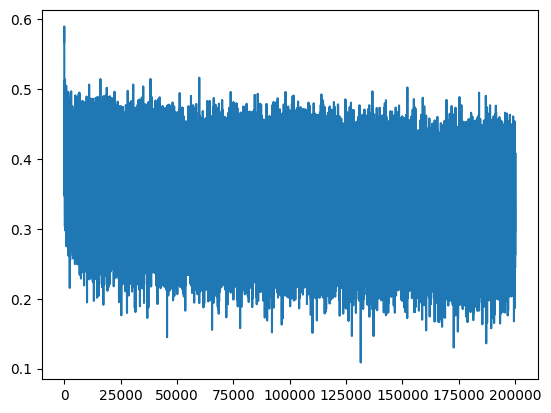

In [12]:
plt.plot(lossi)


In [13]:
torch.tensor(lossi).view(-1, 1000).mean(dim=1).shape


torch.Size([200])

In [14]:
for layer in layers:
    layer.training = False # set to evaluation mode

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")


Train set loss: 2.104525566101074
Validation set loss: 2.134878158569336
Test set loss: 2.133871555328369


In [15]:
@torch.no_grad()
def sample(num_samples: int) ->list[str]:
    names: list[str] = []
    for _ in range(num_samples):
        out: list[str] = []
        context: list[int] = [0] * block_size
        while True:
            emb = C[torch.tensor(context).to(device)]
            emb = emb.view(1, -1)
            for layer in layers:
                emb = layer(emb)
            logits = emb
            probs = F.softmax(logits, dim=1)
            ix: int = int(torch.multinomial(probs, num_samples=1).item())
            out.append(itos[ix])
            context = context[1:] + [ix]
            if ix == 0:
                break
        names.append(''.join(out))
    return names


In [16]:
names: list[str] = sample(20)
for name in names:
    print(name[:-1])


krisa
elle
rapeena
gar
ever
mairishaishaibellive
breigh
murgemin
wyson
olon
mauniciah
sai
smin
viesena
mir
laty
kahcy
dot
don
makeelun


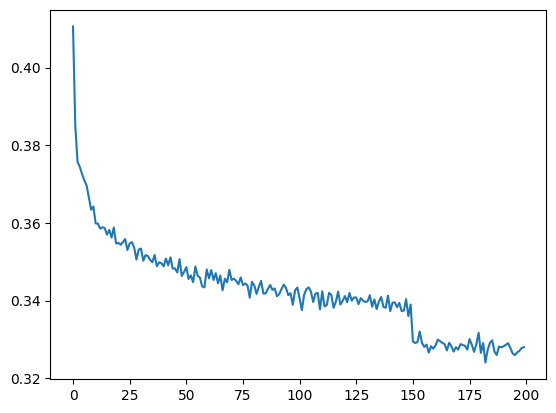

In [17]:
# Make lossi more readable

lossi_ts = torch.tensor(lossi).view(-1, 1000)
lossi_ts = lossi_ts.mean(dim=1)
lossi_ts.shape

plt.plot(lossi_ts)


In [18]:
# Put most operations into the layers

class Sequential:

    def __init__(self, layers: list) -> None:
        self.layers: Final[list] = layers

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out: torch.Tensor = x
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        # Flatten the list of parameters
        return [
            p
            for layer in self.layers
            for p in layer.parameters
        ]

class Embedding:

    def __init__(self, num_embeddings: int, embedding_dim) -> None:
        self.weight: torch.Tensor = torch.randn((num_embeddings,
                                                 embedding_dim)).to(device)

    def __call__(self, IX:torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = self.weight[IX]
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight]

class Flatten:

    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = X.view(X.shape[0], -1)
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return []

class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        # self.weight = (torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)).to(device)
        self.weight = (torch.randn((fan_in, fan_out))).to(device)

        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5,
                 momentum: float = 0.1) -> None:
        # Hyperparameters
        self.eps: float = eps
        self.momentum: float = momentum
        self.training: bool = True

        # Parameters (trainable):
        # gamma and beta are like the weight and bias in a linear layer
        # gamma: scale parameter
        self.gamma = torch.ones(dim).to(device)
        # beta: shift parameter
        self.beta = torch.zeros(dim).to(device)

        # Buffers (trained with momentum):
        # Start from normal distribution.
        self.running_mean: torch.Tensor = torch.zeros(dim).to(device)
        self.running_var: torch.Tensor = torch.ones(dim).to(device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True, unbiased=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_norm = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x_norm_scaled: Final[torch.Tensor] = self.gamma * x_norm + self.beta

        # Update running mean and variance
        if (self.training):
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        self.out: torch.Tensor = x_norm_scaled
        return x_norm_scaled

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = torch.tanh(x)
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return []


In [19]:
n_embd: Final[int] = 10 # embedding dimension
n_hidden: Final[int] = 200 # hidden layer dimension

model = Sequential([
    Embedding(char_cnt, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, char_cnt),
])

with torch.no_grad():
    model.layers[-1].weight *=0.1 # scale down the output weights

parameters: Final[list[torch.Tensor]] = model.parameters
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

max_epochs: Final[int] = 200000
batch_size: Final[int] = 32
lossi: Final[list[float]] = []

for i in range(max_epochs):
    # Prepare mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    logits = model(X_batch)

    # Compute loss
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr: float = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch {i}/{max_epochs}: loss {loss.item():.4f}")
    lossi.append(loss.log10().item())

Number of parameters: 12097
Epoch 0/200000: loss 3.5089
Epoch 10000/200000: loss 2.1750
Epoch 20000/200000: loss 2.0775
Epoch 30000/200000: loss 2.3283
Epoch 40000/200000: loss 2.3805
Epoch 50000/200000: loss 2.1920
Epoch 60000/200000: loss 2.1515
Epoch 70000/200000: loss 2.1820
Epoch 80000/200000: loss 1.7992
Epoch 90000/200000: loss 2.0823
Epoch 100000/200000: loss 1.8045
Epoch 110000/200000: loss 2.2518
Epoch 120000/200000: loss 2.1124
Epoch 130000/200000: loss 2.0809
Epoch 140000/200000: loss 2.0724
Epoch 150000/200000: loss 2.1768
Epoch 160000/200000: loss 2.3006
Epoch 170000/200000: loss 2.0417
Epoch 180000/200000: loss 2.1600
Epoch 190000/200000: loss 2.1788


In [20]:
for layer in model.layers:
    layer.training = False # set to evaluation mode

@torch.no_grad()
def calculate_loss(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")

Train set loss: 2.1094396114349365
Validation set loss: 2.139803886413574
Test set loss: 2.135458469390869


In [21]:
@torch.no_grad()
def sample(num_samples: int) ->list[str]:
    names: list[str] = []
    for _ in range(num_samples):
        out: list[str] = []
        context: list[int] = [0] * block_size
        while True:
            logits = model(torch.tensor([context]).to(device))
            probs = F.softmax(logits, dim=1)
            ix: int = int(torch.multinomial(probs, num_samples=1).item())
            out.append(itos[ix])
            context = context[1:] + [ix]
            if ix == 0:
                break
        names.append(''.join(out))
    return names


In [22]:
names: list[str] = sample(20)
for name in names:
    print(name[:-1])


edi
jedi
hazthan
azary
keyarty
josyn
gtany
zar
rise
gween
darelia
nasiddarariah
lorel
chritza
janne
kellanna
lay
julion
senna
king


In [23]:
# Now increase the context length to from 3 to 8

block_size: Final[int] = 8 # context length
train_set_ratio: float = 0.8
valid_set_ratio: float = 0.1
test_set_ratio: float = 0.1

n1: int = int(len(words) * train_set_ratio)
n2: int = int(len(words) * (train_set_ratio + valid_set_ratio))

X_train, Y_train = create_dataset(words[:n1], block_size)
X_val, Y_val = create_dataset(words[n1:n2], block_size)
X_test, Y_test = create_dataset(words[n2:], block_size)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print(''.join(itos[int(ix.item())] for ix in x), '->', itos[int(y.item())])


........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
........ -> d
.......d -> i
......di -> o
.....dio -> n
....dion -> d
...diond -> r
..diondr -> e
.diondre -> .
........ -> x
.......x -> a
......xa -> v
.....xav -> i
....xavi -> e


In [27]:
n_embd: Final[int] = 10 # embedding dimension
n_hidden: Final[int] = 200 # hidden layer dimension

model = Sequential([
    Embedding(char_cnt, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, char_cnt),
])

with torch.no_grad():
    model.layers[-1].weight *=0.1 # scale down the output weights

parameters: Final[list[torch.Tensor]] = model.parameters
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

max_epochs: Final[int] = 200000
batch_size: Final[int] = 32
lossi: Final[list[float]] = []

for i in range(max_epochs):
    # Prepare mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    logits = model(X_batch)

    # Compute loss
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr: float = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch {i}/{max_epochs}: loss {loss.item():.4f}")
    lossi.append(loss.log10().item())


Number of parameters: 22097
Epoch 0/200000: loss 3.7524
Epoch 10000/200000: loss 2.3424
Epoch 20000/200000: loss 2.0180
Epoch 30000/200000: loss 2.2392
Epoch 40000/200000: loss 2.4045
Epoch 50000/200000: loss 2.1976
Epoch 60000/200000: loss 2.0351
Epoch 70000/200000: loss 2.1820
Epoch 80000/200000: loss 2.4553
Epoch 90000/200000: loss 1.9582
Epoch 100000/200000: loss 2.5674
Epoch 110000/200000: loss 2.1315
Epoch 120000/200000: loss 2.0687
Epoch 130000/200000: loss 2.0962
Epoch 140000/200000: loss 1.9740
Epoch 150000/200000: loss 2.7992
Epoch 160000/200000: loss 2.4496
Epoch 170000/200000: loss 1.9271
Epoch 180000/200000: loss 1.8445
Epoch 190000/200000: loss 1.9705


In [28]:
for layer in model.layers:
    layer.training = False # set to evaluation mode

@torch.no_grad()
def calculate_loss(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")


Train set loss: 2.069547176361084
Validation set loss: 2.1081295013427734
Test set loss: 2.1076202392578125


In [29]:
# Let's look at a batch of just 4 examples
ix = torch.randint(0, X_train.shape[0], (4,))
X_batch, Y_batch = X_train[ix], Y_train[ix]
logits = model(X_batch)
print(f"X_batch shape: {X_batch.shape}")
X_batch

X_batch shape: torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  5, 12,  9],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0,  0, 11,  5,  1],
        [ 0,  0,  0,  0,  0,  0,  4, 15]], device='cuda:0')

In [30]:
# Output of Embedding layer
model.layers[0].out.shape


torch.Size([4, 8, 10])

In [31]:
# Output of Flatten layer
model.layers[1].out.shape


torch.Size([4, 80])

In [32]:
# Output of Linear layer
model.layers[2].out.shape


torch.Size([4, 200])

In [33]:
# Matrix multiplication also works for matrices that are more than 2D
# For example, if we have a 3D tensor and a 2D tensor
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape


torch.Size([4, 5, 200])

In [35]:
# The same applies to 4D tensors
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape


torch.Size([4, 5, 2, 200])

In [36]:
# In our wavenet, we want to diffuse 2 characters at a time, for example:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape


torch.Size([4, 4, 200])

In [41]:
# Goal: get (4, 4, 20) from (4, 8, 10)
e = torch.randn(4, 8, 10)

e[:, ::2, :].shape, e[:, 1::2, :].shape


(torch.Size([4, 4, 10]), torch.Size([4, 4, 10]))

In [44]:
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape


torch.Size([4, 4, 20])

In [43]:
e.view(4, 4, 20).shape


torch.Size([4, 4, 20])

In [45]:
(e.view(4, 4, 20) == explicit).all()


tensor(True)

In [63]:
# Next we will redefine the model to use wavenet architecture:
# Change the flatten layer

class Sequential:

    def __init__(self, layers: list) -> None:
        self.layers: Final[list] = layers

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out: torch.Tensor = x
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        # Flatten the list of parameters
        return [
            p
            for layer in self.layers
            for p in layer.parameters
        ]

class Embedding:

    def __init__(self, num_embeddings: int, embedding_dim) -> None:
        self.weight: torch.Tensor = torch.randn((num_embeddings,
                                                 embedding_dim)).to(device)

    def __call__(self, IX:torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = self.weight[IX]
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n: int) -> None:
        # The number of features to be flatten together.
        self.n = n

    def __call__(self, X: torch.Tensor) -> torch.Tensor:

        n_examples, n_consecutive, n_features = X.shape
        X = X.view(n_examples, n_consecutive // self.n, n_features * self.n)
        if X.shape[1] == 1:
            # If the number of consecutive features is 1, we need to
            # remove the second dimension.
            X = X.squeeze(1)
        self.out: torch.Tensor = X
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return []

class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        # self.weight = (torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)).to(device)
        self.weight = (torch.randn((fan_in, fan_out))).to(device)

        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5,
                 momentum: float = 0.1) -> None:
        # Hyperparameters
        self.eps: float = eps
        self.momentum: float = momentum
        self.training: bool = True

        # Parameters (trainable):
        # gamma and beta are like the weight and bias in a linear layer
        # gamma: scale parameter
        self.gamma = torch.ones(dim).to(device)
        # beta: shift parameter
        self.beta = torch.zeros(dim).to(device)

        # Buffers (trained with momentum):
        # Start from normal distribution.
        self.running_mean: torch.Tensor = torch.zeros(dim).to(device)
        self.running_var: torch.Tensor = torch.ones(dim).to(device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            dim = 0
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True, unbiased=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_norm = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x_norm_scaled: Final[torch.Tensor] = self.gamma * x_norm + self.beta

        # Update running mean and variance
        if (self.training):
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        self.out: torch.Tensor = x_norm_scaled
        return x_norm_scaled

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = torch.tanh(x)
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return []


In [64]:
n_embd: Final[int] = 10 # embedding dimension
n_hidden: Final[int] = 68 # hidden layer dimension

model = Sequential([
    Embedding(char_cnt, n_embd),
    # Dimension 1 will be divided by 2 each time until it reaches 1
    # Since we have 8 characters, we will have 4, 2, 1 which is 3 repetitions.
    FlattenConsecutive(2), Linear(n_embd * 2,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, char_cnt),
])

with torch.no_grad():
    model.layers[-1].weight *=0.1 # scale down the output weights

parameters: Final[list[torch.Tensor]] = model.parameters
for p in parameters:
    p.requires_grad = True
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")


Number of parameters: 22397


In [ ]:
# ix = torch.randint(0, X_train.shape[0], (4,))
# X_batch, Y_batch = X_train[ix], Y_train[ix]
# logits = model(X_batch)
# print(f"X_batch shape: {X_batch.shape}")
# X_batch


X_batch shape: torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0, 11,  1, 19,  8],
        [ 0,  0,  0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]], device='cuda:0')

In [ ]:
# for layer in model.layers:
#     print(layer.__class__.__name__, ": ", layer.out.shape)


Embedding :  torch.Size([4, 8, 10])
FlattenConsecutive :  torch.Size([4, 4, 20])
Linear :  torch.Size([4, 4, 200])
BatchNorm1d :  torch.Size([4, 4, 200])
Tanh :  torch.Size([4, 4, 200])
FlattenConsecutive :  torch.Size([4, 2, 400])
Linear :  torch.Size([4, 2, 200])
BatchNorm1d :  torch.Size([4, 2, 200])
Tanh :  torch.Size([4, 2, 200])
FlattenConsecutive :  torch.Size([4, 400])
Linear :  torch.Size([4, 200])
BatchNorm1d :  torch.Size([4, 200])
Tanh :  torch.Size([4, 200])
Linear :  torch.Size([4, 27])


In [65]:
max_epochs: Final[int] = 200000
batch_size: Final[int] = 32
lossi: Final[list[float]] = []

for i in range(max_epochs):
    # Prepare mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    logits = model(X_batch)

    # Compute loss
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr: float = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch {i}/{max_epochs}: loss {loss.item():.4f}")
    lossi.append(loss.log10().item())


Epoch 0/200000: loss 3.3489
Epoch 10000/200000: loss 2.0137
Epoch 20000/200000: loss 1.8955
Epoch 30000/200000: loss 2.1967
Epoch 40000/200000: loss 2.1274
Epoch 50000/200000: loss 1.9054
Epoch 60000/200000: loss 1.7957
Epoch 70000/200000: loss 2.2776
Epoch 80000/200000: loss 2.1244
Epoch 90000/200000: loss 2.1727
Epoch 100000/200000: loss 1.6592
Epoch 110000/200000: loss 2.1407
Epoch 120000/200000: loss 1.6821
Epoch 130000/200000: loss 1.7696
Epoch 140000/200000: loss 2.2767
Epoch 150000/200000: loss 1.8784
Epoch 160000/200000: loss 1.9729
Epoch 170000/200000: loss 2.2779
Epoch 180000/200000: loss 2.3269
Epoch 190000/200000: loss 2.0493


In [66]:
for layer in model.layers:
    layer.training = False # set to evaluation mode

@torch.no_grad()
def calculate_loss(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")


Train set loss: 2.0582423210144043
Validation set loss: 2.101260185241699
Test set loss: 2.0950379371643066


In [59]:
for layer in model.layers:
    print(layer.__class__.__name__, ": ", layer.out.shape)


Embedding :  torch.Size([22866, 8, 10])
FlattenConsecutive :  torch.Size([22866, 4, 20])
Linear :  torch.Size([22866, 4, 68])
BatchNorm1d :  torch.Size([22866, 4, 68])
Tanh :  torch.Size([22866, 4, 68])
FlattenConsecutive :  torch.Size([22866, 2, 136])
Linear :  torch.Size([22866, 2, 68])
BatchNorm1d :  torch.Size([22866, 2, 68])
Tanh :  torch.Size([22866, 2, 68])
FlattenConsecutive :  torch.Size([22866, 136])
Linear :  torch.Size([22866, 68])
BatchNorm1d :  torch.Size([22866, 68])
Tanh :  torch.Size([22866, 68])
Linear :  torch.Size([22866, 27])


In [60]:
e = torch.randn(32, 4, 68)

e_mean = e.mean(0, keepdim=True)
print(f"e_mean shape: {e_mean.shape}")

e_var = e.var(0, keepdim=True, unbiased=True)
print(f"e_var shape: {e_var.shape}")

e_norm = (e - e_mean) / torch.sqrt(e_var + 1e-5)
print(f"e_norm shape: {e_norm.shape}")


e_mean shape: torch.Size([1, 4, 68])
e_var shape: torch.Size([1, 4, 68])
e_norm shape: torch.Size([32, 4, 68])


In [61]:
e = torch.randn(32, 4, 68)

e_mean = e.mean((0, 1), keepdim=True)
print(f"e_mean shape: {e_mean.shape}")

e_var = e.var((0, 1), keepdim=True, unbiased=True)
print(f"e_var shape: {e_var.shape}")

e_norm = (e - e_mean) / torch.sqrt(e_var + 1e-5)
print(f"e_norm shape: {e_norm.shape}")


e_mean shape: torch.Size([1, 1, 68])
e_var shape: torch.Size([1, 1, 68])
e_norm shape: torch.Size([32, 4, 68])


In [ ]:
# Now with the new wavenet architecture, we can increase the size of the model

n_embd: Final[int] = 24 # embedding dimension
n_hidden: Final[int] = 256 # hidden layer dimension

model = Sequential([
    Embedding(char_cnt, n_embd),
    # Dimension 1 will be divided by 2 each time until it reaches 1
    # Since we have 8 characters, we will have 4, 2, 1 which is 3 repetitions.
    FlattenConsecutive(2), Linear(n_embd * 2,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, char_cnt),
])

with torch.no_grad():
    model.layers[-1].weight *=0.1 # scale down the output weights

parameters: Final[list[torch.Tensor]] = model.parameters
for p in parameters:
    p.requires_grad = True
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

max_epochs: Final[int] = 200000
batch_size: Final[int] = 128
lossi: Final[list[float]] = []

for i in range(max_epochs):
    # Prepare mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    logits = model(X_batch)

    # Compute loss
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch {i}/{max_epochs}: loss {loss.item():.4f}")
    lossi.append(loss.log10().item())


Number of parameters: 283555
Epoch 0/200000: loss 3.8512
Epoch 10000/200000: loss 2.0591
Epoch 20000/200000: loss 2.1294
Epoch 30000/200000: loss 2.0387
Epoch 40000/200000: loss 2.0783
Epoch 50000/200000: loss 2.0901
Epoch 60000/200000: loss 2.1637
Epoch 70000/200000: loss 2.1572
Epoch 80000/200000: loss 1.9569
Epoch 90000/200000: loss 1.9441
Epoch 100000/200000: loss 1.9598
Epoch 110000/200000: loss 1.8421
Epoch 120000/200000: loss 1.9947
Epoch 130000/200000: loss 1.9633
Epoch 140000/200000: loss 1.8099
Epoch 150000/200000: loss 1.9765
Epoch 160000/200000: loss 1.8246
Epoch 170000/200000: loss 1.6702
Epoch 180000/200000: loss 2.0937
Epoch 190000/200000: loss 1.9080


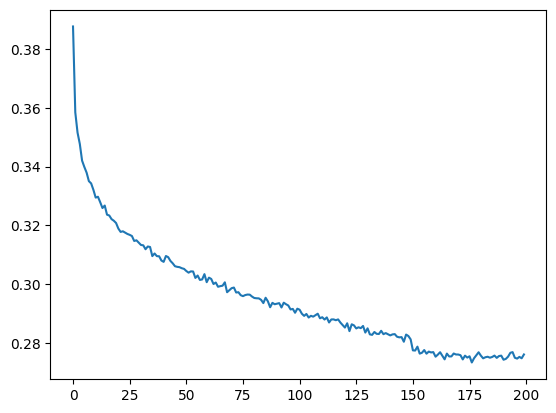

In [77]:
# Make lossi more readable

lossi_ts = torch.tensor(lossi).view(-1, 1000)
lossi_ts = lossi_ts.mean(dim=1)
lossi_ts.shape

plt.plot(lossi_ts)


In [78]:
for layer in model.layers:
    layer.training = False # set to evaluation mode

print(f"Train set loss: {calculate_loss(X_train, Y_train).item()}")
print(f"Validation set loss: {calculate_loss(X_val, Y_val).item()}")
print(f"Test set loss: {calculate_loss(X_test, Y_test).item()}")


Train set loss: 1.868202567100525
Validation set loss: 2.0243759155273438
Test set loss: 2.0304033756256104
